## Data Akuisisi

In [1]:
# !pip uninstall -y kagglehub
# !pip install kagglehub==0.3.13

In [2]:
import kagglehub
import os
import numpy as np
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, zscore, norm, shapiro, kruskal

C:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pastikan file kaggle.json ada di C:\Users\<namaakun>\.kaggle

In [3]:
pd.set_option('display.max_columns', None) 

In [4]:
# api = KaggleApi()
# api.authenticate()

# dataset = "uom190346a/sleep-health-and-lifestyle-dataset"
# folder_tujuan = "data"
# api.dataset_download_files(dataset, path=folder_tujuan, unzip=True)

# print(f"Dataset berhasil di-download ke folder: {folder_tujuan}")

In [5]:
df = pd.read_csv(f'data/Sleep_health_and_lifestyle_dataset.csv')
df.head(2)

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN


In [6]:
df.info()
df['Sleep Disorder'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


Sleep Disorder
Sleep Apnea    78
Insomnia       77
Name: count, dtype: int64

Sleep Disorder: The presence or absence of a sleep disorder in the person (None, Insomnia, Sleep Apnea).

In [7]:
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('No Disorder')
df[['Systolic Pressure', 'Diastolic Pressure']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)
df_corr = df.drop(columns=['Person ID', 'Blood Pressure'])

df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   374 non-null    object 
 1   Age                      374 non-null    int64  
 2   Occupation               374 non-null    object 
 3   Sleep Duration           374 non-null    float64
 4   Quality of Sleep         374 non-null    int64  
 5   Physical Activity Level  374 non-null    int64  
 6   Stress Level             374 non-null    int64  
 7   BMI Category             374 non-null    object 
 8   Heart Rate               374 non-null    int64  
 9   Daily Steps              374 non-null    int64  
 10  Sleep Disorder           374 non-null    object 
 11  Systolic Pressure        374 non-null    int64  
 12  Diastolic Pressure       374 non-null    int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 38.1+ KB


In [8]:
df['Sleep Disorder'].value_counts()

Sleep Disorder
No Disorder    219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64

### Distribusi

In [9]:
categorical_vars = ['Gender', 'Occupation', 'Quality of Sleep', 'Stress Level', 'BMI Category']
target = 'Sleep Disorder'
numerical_vars = [col for col in df_corr.columns if col not in categorical_vars + [target] and df_corr[col].dtype in ['int64', 'float64']]

scale_map = {
    'Gender': 'Nominal',
    'Age': 'Rasio',
    'Occupation': 'Nominal',
    'Sleep Duration': 'Rasio',
    'Quality of Sleep': 'Ordinal',
    'Physical Activity Level': 'Rasio',
    'Stress Level': 'Ordinal',
    'BMI Category': 'Ordinal',
    'Heart Rate': 'Rasio',
    'Daily Steps': 'Rasio',
    'Sleep Disorder': 'Nominal',
    'Systolic Pressure': 'Rasio',
    'Diastolic Pressure': 'Rasio'
}

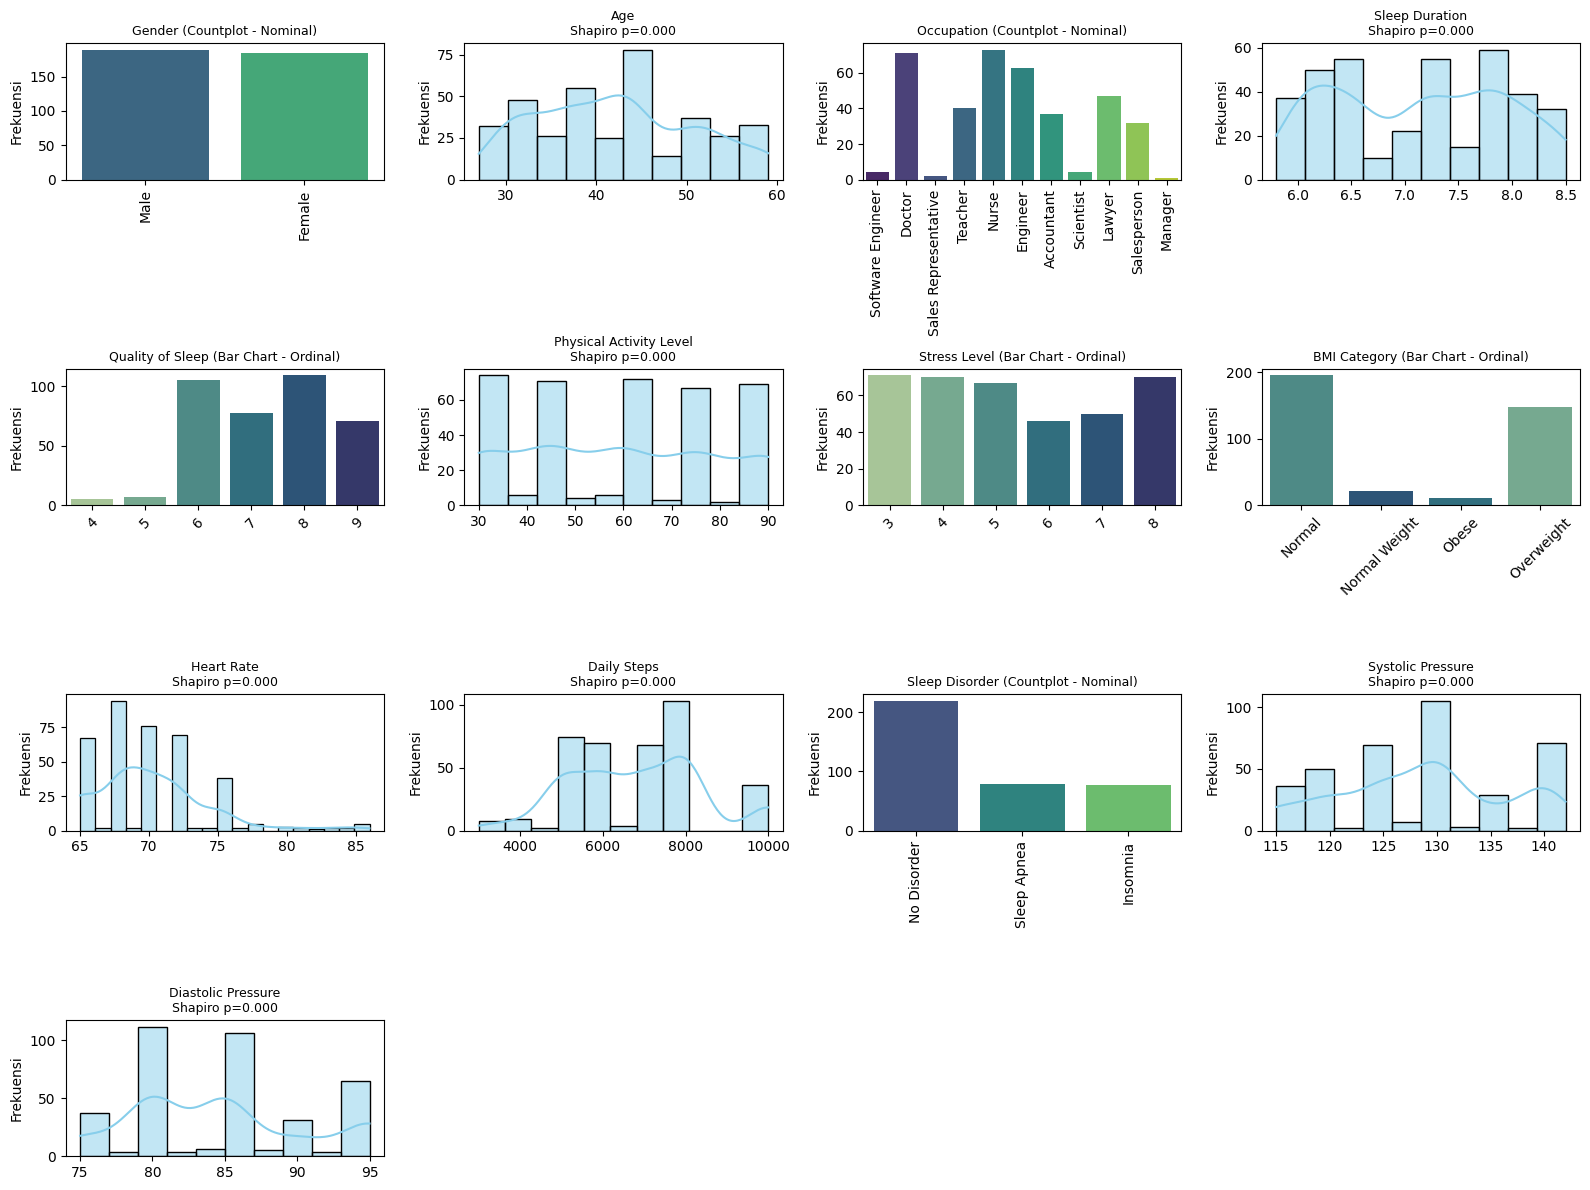

In [10]:
cols = 4
num_vars = len(df_corr.columns)
rows = (num_vars + cols - 1) // cols

plt.figure(figsize=(cols * 4, rows * 3))

for i, col in enumerate(df_corr.columns, 1):
    plt.subplot(rows, cols, i)
    scale = scale_map.get(col, 'Rasio') 

    if scale in ['Rasio', 'Interval']:
        data = df_corr[col].dropna()
        stat, p_val = shapiro(data)

        sns.histplot(data, kde=True, color='skyblue', edgecolor='black')
        plt.title(f"{col}\nShapiro p={p_val:.3f}", fontsize=9)
        plt.xlabel('')
        plt.ylabel('Frekuensi')

    elif scale == 'Ordinal':
        order = sorted(df_corr[col].dropna().unique())
        sns.countplot(x=col, hue=col, data=df_corr, order=order, palette='crest', legend=False)
        plt.title(f"{col} (Bar Chart - Ordinal)", fontsize=9)
        plt.xticks(rotation=45)

    elif scale == 'Nominal':
        sns.countplot(x=col, hue=col, data=df_corr, palette='viridis', legend=False)
        plt.title(f"{col} (Countplot - Nominal)", fontsize=9)
        plt.xticks(rotation=90)

    plt.xlabel('')
    plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()

#### Uji Normalitas Shapiro-Wilk

**Hipotesis:**

- **H₀ (Hipotesis nol):** Data berasal dari distribusi normal.  
- **H₁ (Hipotesis alternatif):** Data **tidak** berasal dari distribusi normal.

**p-value:**

- **p > 0.05:** Gagal menolak H₀ → data tidak berbeda signifikan dari normal → dianggap **normal**.  
- **p ≤ 0.05:** Tolak H₀ → data berbeda signifikan dari normal → dianggap **tidak normal**.

**Kesimpulan**  
P-value < 0.05 untuk semua variabel Rasio/Interval, sehingga **tidak ada variabel yang berdistribusi normal**.

### Analisis Korelasi

| Tipe Variabel  | Kuantitatif                           | Ordinal                   | Nominal                 |
| -------------- | ------------------------------------- | ------------------------- | ----------------------- |
| **Kuantiatif (X)** | Pearson r / Spearman rs / Kendall tau | -                         | -                       |
| **Ordinal (X)**    | Biserial rb                           | Spearman rs / Kendall tau | -                       |
| **Nominal (X)**    | Point biserial rpb                    | Rank biserial rrb         | Phi, Cramer’s V, Lambda |


| Variabel X                | Variabel Y            | Distribusi / Normalitas              | Linearitas | Jumlah Kategori / Sampel | Metode Analisis Korelasi / Uji      | Keterangan Singkat                                                     |
| ------------------------- | --------------------- | ------------------------------------ | ---------- | ------------------------ | ----------------------------------- | ---------------------------------------------------------------------- |
| Rasio / Interval      | Rasio / Interval  | Normal                               | Linear     | -                        | **Pearson’s r**                     | Kekuatan & arah hubungan linear antar dua variabel kontinu.            |
| Rasio / Interval          | Rasio / Interval      | Tidak normal                         | Monotonik  | -                        | **Spearman’s ρ** / **Kendall’s τ**  | Nonparametrik, cocok untuk data tidak normal atau hubungan non-linear. |
| Rasio / Interval          | Nominal (2 kategori)  | Normal                               | -          | Dua kategori             | **Point Biserial (rₚb)**            | Versi Pearson untuk variabel biner (0/1).                              |
| Rasio / Interval          | Nominal (2 kategori)  | Tidak normal                         | -          | Dua kategori, n kecil    | **Mann–Whitney U Test**             | Nonparametrik pengganti t-test.                                        |
| Rasio / Interval          | Nominal (>2 kategori) | Normal, homogen                      | -          | ≥3 kategori              | **One-way ANOVA**                   | Uji beda rata-rata antar kelompok kategori.                            |
| **Rasio / Interval**          | **Nominal (>2 kategori)** | **Tidak normal / varians tidak homogen** | -          | **≥3 kategori**              | **Kruskal–Wallis Test**             | **Nonparametrik pengganti ANOVA.**                                         |
| Ordinal                   | Ordinal               | -                                    | Monotonik  | -                        | **Spearman’s ρ / Kendall’s τ**      | Korelasi ranking antar dua variabel ordinal.                           |
| Ordinal                   | Nominal (2 kategori)  | -                                    | -          | Dua kategori             | **Rank Biserial (rᵣb)**             | Hubungan ranking dengan variabel biner.                                |
| **Ordinal**                   | **Nominal (>2 kategori)** | -                 | -          | **≥3 kategori**              | **Kruskal–Wallis Test**             | **Bandingkan ranking antar banyak kategori.**|
| Nominal (2 kategori)      | Nominal (2 kategori)  | -                                    | -          | n kecil                  | **Fisher’s Exact Test**             | Tepat untuk tabel 2x2 dengan sampel kecil.                             |
| Nominal (2 kategori)      | Nominal (2 kategori)  | -                                    | -          | n besar                  | **Chi-Square Test**                 | Uji asosiasi antar dua variabel kategori.                              |
| **Nominal (>2 kategori)**     | **Nominal (>2 kategori)** | -                                    | -          | **≥3 kategori**              | **Cramer’s V / Lambda**             | **Ukur kekuatan asosiasi antar variabel kategorik.**                       |
| Rasio / Interval (banyak) | Nominal (2 kategori)  | -                                    | -          | Dua kategori             | **Binary Logistic Regression**      | Prediksi kategori biner dari variabel kontinu.                         |
| Rasio / Interval (banyak) | Nominal (>2 kategori) | -                                    | -          | ≥3 kategori              | **Multinomial Logistic Regression** | Prediksi kategori multinomial (misal Sleep Disorder).                  |


| Kolom                   | Deskripsi                                                           | Skala   | Metode Analisis Korelasi        |
| ----------------------- | ------------------------------------------------------------------- | ------- | ------------------------------- |
| Gender                  | Jenis kelamin orang (Laki-laki/Perempuan)                           | Nominal | Cramer’s V                      |
| Age                     | Usia orang dalam tahun                                              | Rasio   | Kruskal–Wallis Test |
| Occupation              | Pekerjaan atau profesi orang                                        | Nominal |  Cramer’s V                         |
| Sleep Duration          | Jumlah jam tidur per hari                                           | Rasio   | Kruskal–Wallis Test |
| Quality of Sleep        | Penilaian subjektif kualitas tidur (1-10)                           | Ordinal | Kruskal–Wallis Test                          |
| Physical Activity Level | Jumlah menit aktivitas fisik per hari                               | Rasio   | Kruskal–Wallis Test |
| Stress Level            | Penilaian subjektif tingkat stres (1-10)                            | Ordinal | Kruskal–Wallis Test                          |
| BMI Category            | Kategori BMI                                             | Ordinal | Kruskal–Wallis Test                 |
| Heart Rate              | Detak jantung istirahat per menit                                   | Rasio   | Kruskal–Wallis Test |
| Daily Steps             | Jumlah langkah per hari                                             | Rasio   | Kruskal–Wallis Test |
| Sleep Disorder          | Ada atau tidaknya gangguan tidur (Tidak ada, Insomnia, Sleep Apnea) | Nominal | Dependen                        |
| Systolic Pressure       | Tekanan darah sistolik                                              | Rasio   | Kruskal–Wallis Test |
| Diastolic Pressure      | Tekanan darah diastolik                                             | Rasio   | Kruskal–Wallis Test |

#### Analisis Korelasi Variabel Ordinal

In [11]:
ordinal_vars = [var for var, scale in scale_map.items() if scale == 'Ordinal']
results = []
for var in ordinal_vars:
    groups = [df[df[target] == cat][var].dropna() for cat in df[target].unique()]
    stat, p = kruskal(*groups)
    
    results.append({
        'Variable': var,
        'Kruskal-Wallis H': stat,
        'p-value': p,
        'Significant (α=0.05)': 'Yes' if p < 0.05 else 'No'
    })

df_kw_ordinal = pd.DataFrame(results)
print(df_kw_ordinal)

           Variable  Kruskal-Wallis H       p-value Significant (α=0.05)
0  Quality of Sleep         49.178905  2.093806e-11                  Yes
1      Stress Level         10.042155  6.597414e-03                  Yes
2      BMI Category        229.399481  1.536511e-50                  Yes


* **Jika p-value < α (misal 0.05)** → hubungan signifikan → ada indikasi variabel X berhubungan dengan variabel Y.
* **Jika p-value ≥ α** → tidak signifikan → tidak ada bukti hubungan.

Quality of Sleep vs Sleep Disorder: Nilai p-value sangat kecil (2.09×10⁻¹¹ < 0.05), menunjukkan terdapat hubungan yang signifikan antara kualitas tidur dan jenis gangguan tidur. Artinya, distribusi ranking kualitas tidur berbeda secara signifikan antar kategori Sleep Disorder (No Disorder, Insomnia, Sleep Apnea).

Stress Level vs Sleep Disorder: Nilai p-value juga lebih kecil dari 0.05 (6.59×10⁻³), menunjukkan ada hubungan yang signifikan antara tingkat stres dan jenis gangguan tidur. Distribusi ranking tingkat stres berbeda secara signifikan antar kategori Sleep Disorder.

#### Analisis Korelasi Variabel Nominal

In [12]:
from scipy.stats import chi2_contingency

nominal_vars = ['Gender', 'Occupation']
def cramers_v(x, y):
    contingency = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(contingency)
    n = contingency.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency.shape)-1)))

results = []
for col in nominal_vars:
    cv = cramers_v(df[col], df[target])
    results.append({'Variable': col, "Cramer's V": cv})

df_cramers = pd.DataFrame(results)
print(df_cramers)

     Variable  Cramer's V
0      Gender    0.381055
1  Occupation    0.750546


| Cramer’s V  | Kekuatan hubungan (rule of thumb) |
| ----------- | --------------------------------- |
| 0.00 – 0.10 | Sangat lemah / hampir tidak ada   |
| 0.10 – 0.30 | Lemah                             |
| 0.30 – 0.50 | Sedang                            |
| 0.50 – 0.70 | Kuat                              |
| 0.70 – 1.00 | Sangat kuat                       |


Semua variabel nominal yang dianalisis memiliki hubungan dengan Sleep Disorder, dengan kekuatan bervariasi: Occupation paling berpengaruh, diikuti BMI, lalu Gender.

#### Analisis Korelasi Variabel Kontinu

In [13]:
print(numerical_vars)

['Age', 'Sleep Duration', 'Physical Activity Level', 'Heart Rate', 'Daily Steps', 'Systolic Pressure', 'Diastolic Pressure']


In [14]:
import pandas as pd

results = []

for col in numerical_vars:
    # Buat list nilai numerik per kategori target
    groups = [df_corr[df_corr[target]==cat][col].dropna() for cat in df_corr[target].unique()]
    
    stat, p = kruskal(*groups)
    results.append({
        'Variable': col,
        'Kruskal-Wallis H': stat,
        'p-value': p,
        'Significant (α=0.05)': 'Yes' if p < 0.05 else 'No'
    })

kruskal_df = pd.DataFrame(results)
kruskal_df


,Variable,Kruskal-Wallis H,p-value,Significant (α=0.05)
0,Age,84.756989,3.937801e-19,Yes
1,Sleep Duration,43.898866,2.934151e-10,Yes
2,Physical Activity Level,70.406535,5.145353e-16,Yes
3,Heart Rate,37.275207,8.049923e-09,Yes
4,Daily Steps,38.807177,3.742214e-09,Yes
5,Systolic Pressure,205.502213,2.375536e-45,Yes
6,Diastolic Pressure,211.497307,1.185614e-46,Yes


Semua variabel numerik menunjukkan **hubungan signifikan** dengan Sleep Disorder karena **p-value < 0.05**. Artinya, faktor-faktor seperti umur, jam tidur, aktivitas fisik, detak jantung, jumlah langkah, dan tekanan darah **berkaitan dengan jenis gangguan tidur**, ditandai dengan perbedaan distribusi variabel-variabel ini antar kategori Sleep Disorder.


### Analisis Regresi Logistik Multinomial

In [15]:
df_enc = df.copy()
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           374 non-null    object 
 13  Systolic Pressure        374 non-null    int64  
 14  Diastolic Pressure       3

In [16]:
df['Occupation'].unique()
df['Occupation'].value_counts()

Occupation
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Scientist                4
Software Engineer        4
Sales Representative     2
Manager                  1
Name: count, dtype: int64

In [17]:
df_enc = df.copy()
cols = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder'] # cols: ordinal & nominal
for col in cols:
    if col in ['Occupation', 'BMI Category']:
        print(col)
        if col == 'BMI Category':
            df_enc['BMI Category'] = df_enc['BMI Category'].replace('Normal Weight', 'Normal')
        baseline = df_enc[col].value_counts().idxmax() # Nurse 
        dummies = pd.get_dummies(df_enc[col], drop_first=False)
        dummies = dummies.drop(columns=[baseline])
        df_enc = pd.concat([df_enc.drop(columns=[col]), dummies], axis=1)
    else:
        le = LabelEncoder()
        df_enc[col] = le.fit_transform(df[col])
        print(f'{col}: {df_enc[col].unique()}')
        print(le.classes_)
        print()

Gender: [1 0]
['Female' 'Male']

Occupation
BMI Category
Sleep Disorder: [1 2 0]
['Insomnia' 'No Disorder' 'Sleep Apnea']



karena jarak level bmi nya jauh, maka perlu didummy kan <br>
pertimbangan:
- sleep disorder dikira ordinal
- bmi category belum ada data yg benar

#### Cek Multikolinearitas

In [18]:
X_vif = df_enc.drop(columns=['Person ID', 'Blood Pressure', target]).astype(float)
X_vif = add_constant(X_vif)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)

                   Variable          VIF
0                     const  9282.034017
1                    Gender    11.214336
2                       Age    20.098211
3            Sleep Duration    11.249439
4          Quality of Sleep    28.396296
5   Physical Activity Level     7.178047
6              Stress Level    24.236812
7                Heart Rate    10.755717
8               Daily Steps     8.439698
9         Systolic Pressure   109.907974
10       Diastolic Pressure   121.691867
11               Accountant     5.409273
12                   Doctor    12.765037
13                 Engineer    10.096119
14                   Lawyer     7.750325
15                  Manager     1.137655
16     Sales Representative     1.977786
17              Salesperson     8.124332
18                Scientist     1.577411
19        Software Engineer     1.705357
20                  Teacher     4.925042
21                    Obese     6.191614
22               Overweight    14.793310


In [19]:
df_novif = df_enc.drop(columns=['Person ID', 'Blood Pressure', 'Sleep Disorder','Gender','Age', 'Sleep Duration', 'Quality of Sleep', 'Daily Steps', 
                                'Stress Level', 'Heart Rate', 'Systolic Pressure', 'Diastolic Pressure', 'Doctor', 'Engineer', 'Overweight'])

In [20]:
rasio_cols = [
    # 'Age', 'Sleep Duration','Heart Rate','Systolic Pressure', 'Diastolic Pressure','Daily Steps',
    'Physical Activity Level',  ]

scaler = StandardScaler()
df_novif[rasio_cols] = scaler.fit_transform(df_novif[rasio_cols])

ordinal dlm regresi tidak perlu di standarisasi

In [21]:
X = df_novif.astype(float)
y = df_enc[target]

In [22]:
X.head(2)

,Physical Activity Level,Accountant,Lawyer,Manager,Sales Representative,Salesperson,Scientist,Software Engineer,Teacher,Obese
0,-0.825418,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.039844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
pd.crosstab([X['Obese'], X['Software Engineer']], y)

Sleep Disorder            0    1   2
Obese Software Engineer             
0.0   0.0                73  216  72
      1.0                 0    3   0
1.0   0.0                 3    0   6
      1.0                 1    0   0

In [24]:
X.isnull().sum()
y.isnull().sum()

y.value_counts()

Sleep Disorder
1    219
2     78
0     77
Name: count, dtype: int64

In [25]:
y_cat = pd.Categorical(y)
y_codes = y_cat.codes
print("Urutan kategorinya:", y_cat.categories)

X_const = add_constant(X, prepend=True)
X_np = np.asarray(X_const, dtype=float)
y_np = np.asarray(y_codes, dtype=int)

Urutan kategorinya: Index([0, 1, 2], dtype='int64')


In [26]:
print("Shape X_np:", X_np.shape, "dtype:", X_np.dtype)
print("Shape y_np:", y_np.shape, "dtype:", y_np.dtype)

Shape X_np: (374, 11) dtype: float64
Shape y_np: (374,) dtype: int64


In [27]:
mnlogit_model = sm.MNLogit(y_np, X_np)
mnlogit_result = mnlogit_model.fit_regularized()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5764033979643546
            Iterations: 141
            Function evaluations: 141
            Gradient evaluations: 141


In [28]:
print(mnlogit_result.summary())

                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  374
Model:                        MNLogit   Df Residuals:                      352
Method:                           MLE   Df Model:                           20
Date:                Fri, 05 Dec 2025   Pseudo R-squ.:                  0.4031
Time:                        16:04:47   Log-Likelihood:                -215.57
converged:                       True   LL-Null:                       -361.17
Covariance Type:            nonrobust   LLR p-value:                 5.075e-50
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6702      0.356      7.496      0.000       1.972       3.368
x1             0.3336      0.274      1.218      0.223      -0.203       0.870
x2            -1.1932      0.545     -2.188      0.0

C:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\discrete\discrete_model.py:5475: RuntimeWarning: invalid value encountered in sqrt
  bse = np.sqrt(np.diag(self.cov_params()))


### Machine Learning

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [30]:
df = pd.read_csv(f'data/Sleep_health_and_lifestyle_dataset.csv')

In [31]:
if 'Blood Pressure' in df.columns:
    bp_split = df['Blood Pressure'].str.split('/', expand=True)
    df['Systolic'] = pd.to_numeric(bp_split[0], errors='coerce')
    df['Diastolic'] = pd.to_numeric(bp_split[1], errors='coerce')
    df.drop(columns=['Blood Pressure'], inplace=True)

df['Sleep Disorder'] = df['Sleep Disorder'].fillna('No Disorder')

bmi_mapping = {'Normal': 0,
               'Overweight': 1,
               'Obese': 2}
df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')
print(df['BMI Category'].unique())
df['BMI Category'] = df['BMI Category'].map(bmi_mapping)

['Overweight' 'Normal' 'Obese']


In [32]:
X = df.drop(columns=['Person ID', 'Sleep Disorder'])
y = df['Sleep Disorder']

print("Fitur:", X.columns.tolist())
print("Target size:", y.shape)
X.info()

Fitur: ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']
Target size: (374,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   374 non-null    object 
 1   Age                      374 non-null    int64  
 2   Occupation               374 non-null    object 
 3   Sleep Duration           374 non-null    float64
 4   Quality of Sleep         374 non-null    int64  
 5   Physical Activity Level  374 non-null    int64  
 6   Stress Level             374 non-null    int64  
 7   BMI Category             374 non-null    int64  
 8   Heart Rate               374 non-null    int64  
 9   Daily Steps              374 non-null    int64  
 10  Systolic                 374 non

In [33]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

In [34]:
label_encoders = {}
for col in cat_cols:
    le_col = LabelEncoder()
    X[col] = le_col.fit_transform(X[col])
    label_encoders[col] = le_col

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)
print("Kelas target:", le_y.classes_)

Kelas target: ['Insomnia' 'No Disorder' 'Sleep Apnea']


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [36]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

In [37]:
models = {
    "Naive Bayes (GaussianNB)": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF)": SVC(kernel='rbf', probability=True, random_state=42)
}

In [38]:
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    print("="*60)
    print(f"Model: {name}")
    print(f"Akurasi: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le_y.classes_))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    report = classification_report(y_test, y_pred, target_names=le_y.classes_, output_dict=True)
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Macro_Precision': report['macro avg']['precision'],
        'Macro_F1':  report['macro avg']['f1-score']
    })

Model: Naive Bayes (GaussianNB)
Akurasi: 0.9333
Classification Report:
              precision    recall  f1-score   support

    Insomnia       0.78      0.93      0.85        15
 No Disorder       1.00      0.95      0.98        44
 Sleep Apnea       0.93      0.88      0.90        16

    accuracy                           0.93        75
   macro avg       0.90      0.92      0.91        75
weighted avg       0.94      0.93      0.94        75

Confusion Matrix:
[[14  0  1]
 [ 2 42  0]
 [ 2  0 14]]
Model: Decision Tree
Akurasi: 0.9200
Classification Report:
              precision    recall  f1-score   support

    Insomnia       0.74      0.93      0.82        15
 No Disorder       1.00      0.95      0.98        44
 Sleep Apnea       0.93      0.81      0.87        16

    accuracy                           0.92        75
   macro avg       0.89      0.90      0.89        75
weighted avg       0.93      0.92      0.92        75

Confusion Matrix:
[[14  0  1]
 [ 2 42  0]
 [ 3  0 13

In [39]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Macro_F1', ascending=False)
print("\n=== Ringkasan Hasil 5 Model ===")
print(results_df)



=== Ringkasan Hasil 5 Model ===
                      Model  Accuracy  Macro_Precision  Macro_F1
2             Random Forest  0.960000         0.937500  0.943077
0  Naive Bayes (GaussianNB)  0.933333         0.903704  0.909485
4                 SVM (RBF)  0.933333         0.898284  0.908182
3                 KNN (k=5)  0.920000         0.908915  0.893268
1             Decision Tree  0.920000         0.888471  0.888980


In [ ]:
tree_estimator = model.estimators_[0]

plt.figure(figsize=(25, 15))
plot_tree(
    tree_estimator,
    feature_names=X_train_scaled.columns,
    class_names=le_y.classes_,
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()